In [26]:
# !pip install -q tensorflow scikit-learn matplotlib pandas joblib

import os, sys, csv, json, joblib, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences

sys.path.append(str(pathlib.Path().resolve()))
from intento.config import MAX_VOCAB, MAX_LEN, DATA_PATH, MODEL_PATH, TOKEN_PATH, LABEL_PATH
from intento.predict import predict_intent


## 1

In [27]:
df = pd.read_csv(DATA_PATH)
print(f"Samples: {len(df):,},  Columns: {list(df.columns)}")
df.head()

Samples: 500,  Columns: ['utterance', 'intent']


,utterance,intent
0,Weather report right now?,weather.request
1,Do I need an umbrella.,weather.request
2,How's the weather right now.,weather.request
3,Do I need an umbrella,weather.request
4,Give me the forecast today?,weather.request


## 2

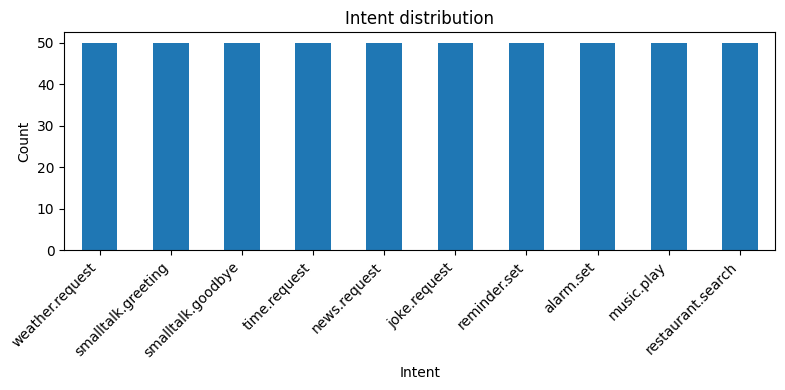

In [28]:
plt.figure(figsize=(8,4))
df['intent'].value_counts().plot(kind='bar')
plt.title('Intent distribution')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

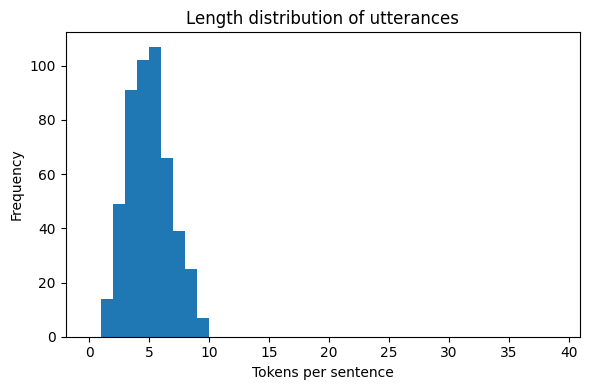

In [29]:
sent_lengths = df['utterance'].str.split().apply(len)
plt.figure(figsize=(6,4))
plt.hist(sent_lengths, bins=range(0, MAX_LEN*2))
plt.title('Length distribution of utterances')
plt.xlabel('Tokens per sentence')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 3 Tokenizer

In [30]:
tok = joblib.load(TOKEN_PATH)
print(f"Vocabulary size: {len(tok.word_index):,}")
print('Top‑20 tokens:')
for w, idx in list(tok.word_index.items())[:20]:
    print(f"{idx:>4d}  {w}")

Vocabulary size: 171
Top‑20 tokens:
   1  <UNK>
   2  please
   3  me
   4  now
   5  the
   6  a
   7  for
   8  time
   9  alarm
  10  news
  11  play
  12  set
  13  to
  14  tomorrow
  15  you
  16  there
  17  at
  18  weather
  19  tell
  20  i


## 4 Prepare sequences / labels

In [31]:
texts  = df['utterance'].tolist()
labels = df['intent'].tolist()

# loadl label encoder and transform labels
le = joblib.load(LABEL_PATH)
y = le.transform(labels)

# create sequences and pad them to MAX_LEN
seqs = tok.texts_to_sequences(texts)
X    = pad_sequences(seqs, maxlen=MAX_LEN, padding='post')

print(f"Input shape: {X.shape},  Label shape: {y.shape}")

Input shape: (500, 20),  Label shape: (500,)


## 5 Evaluation

In [32]:
model = tf.keras.models.load_model(MODEL_PATH)
loss, acc = model.evaluate(X, y, verbose=0)
print(f"Total accuracy on the complete data set: {acc:.2%}")

Total accuracy on the complete data set: 100.00%


In [33]:
y_pred = np.argmax(model.predict(X, verbose=0), axis=1)
print(classification_report(y, y_pred, target_names=le.classes_))

                    precision    recall  f1-score   support

         alarm.set       1.00      1.00      1.00        50
      joke.request       1.00      1.00      1.00        50
        music.play       1.00      1.00      1.00        50
      news.request       1.00      1.00      1.00        50
      reminder.set       1.00      1.00      1.00        50
 restaurant.search       1.00      1.00      1.00        50
 smalltalk.goodbye       1.00      1.00      1.00        50
smalltalk.greeting       1.00      1.00      1.00        50
      time.request       1.00      1.00      1.00        50
   weather.request       1.00      1.00      1.00        50

          accuracy                           1.00       500
         macro avg       1.00      1.00      1.00       500
      weighted avg       1.00      1.00      1.00       500



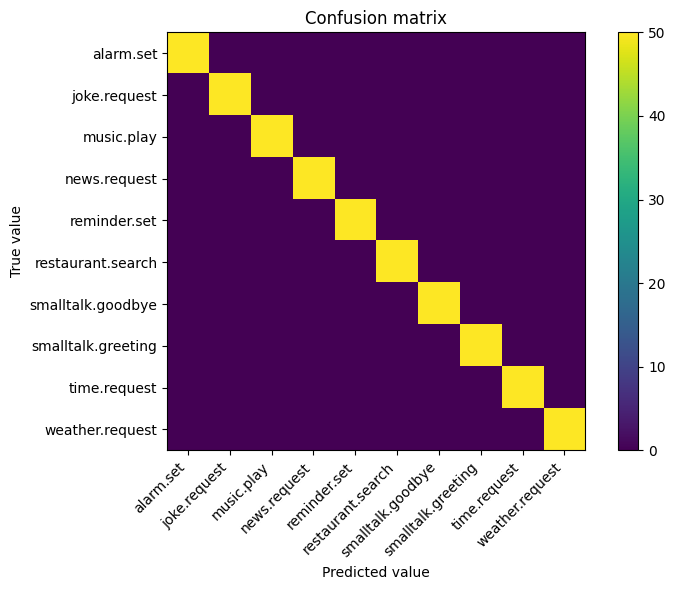

In [34]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.tight_layout()
plt.show()

## 6 Example predictions

In [ ]:
examples = [
    "book me a flight to Berlin next Monday",
    "what's the weather like tomorrow",
    "play some jazz music"
]

for text in examples:
    intent, conf = predict_intent(text)
    print(f"{text!r:55s} ---> {intent:<20s} ({conf:.1%})")

'book me a flight to Berlin next Monday'                -> reminder.set         (86.2%)
"what's the weather like tomorrow"                      -> weather.request      (100.0%)
'play some jazz music'                                  -> music.play           (100.0%)
